In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import curve_fit

In [2]:
colordic = {1: "C0", 2: "C1", "g": "C0", "r": "C1"}

In [3]:
# Define the data
data = {
    'id': ['ZTF23abdhvou'] * 8,
    'type': ['Ia'] * 8,
    'MJD': [2.460208e+06, 2.460206e+06, 2.460204e+06, 2.460202e+06, 2.460212e+06, 2.460208e+06, 2.460206e+06, 2.460204e+06],
    'FLT': ['g', 'g', 'g', 'g', 'r', 'r', 'r', 'r'],
    'FLUXCAL': [2357.275812, 1588.985741, 1111.092971, 740.316792, 2735.228418, 1987.126889, 1442.779623, 1076.971969],
    'FLUXCALERR': [264.237663, 145.960338, 157.389005, 139.299161, 194.408301, 146.647424, 147.874434, 177.146771]
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

             id type        MJD FLT      FLUXCAL  FLUXCALERR
0  ZTF23abdhvou   Ia  2460208.0   g  2357.275812  264.237663
1  ZTF23abdhvou   Ia  2460206.0   g  1588.985741  145.960338
2  ZTF23abdhvou   Ia  2460204.0   g  1111.092971  157.389005
3  ZTF23abdhvou   Ia  2460202.0   g   740.316792  139.299161
4  ZTF23abdhvou   Ia  2460212.0   r  2735.228418  194.408301
5  ZTF23abdhvou   Ia  2460208.0   r  1987.126889  146.647424
6  ZTF23abdhvou   Ia  2460206.0   r  1442.779623  147.874434
7  ZTF23abdhvou   Ia  2460204.0   r  1076.971969  177.146771


In [4]:
# features from ACTSNFink
from actsnfink import *
alerts_features = featurize_full_dataset(
                df,
                screen=False,
                ewma_window=3,
                min_rising_points=1,
                min_data_points=3,
                rising_criteria="ewma",
            )
print(alerts_features)

             id type      a_g        b_g           c_g  snratio_g     mse_g  \
0  ZTF23abdhvou   Ia  0.19201  34.240885  535136.56333   8.045395  0.000004   

   nrise_g       a_r       b_r         c_r  snratio_r     mse_r  nrise_r  
0        4  0.274882  2.949715  3423.74452  10.864052  0.000017        4  


In [5]:
def sigmoid(t, c, a, b):
        return c / (1 + np.exp(-a * (t - b)))

out
2633.9610066223972 0.5823444982542539 60204.2968853667
out
2681.138310782883 0.6616095600109378 60205.32172177583


Text(0, 0.5, 'FLUXCAL')

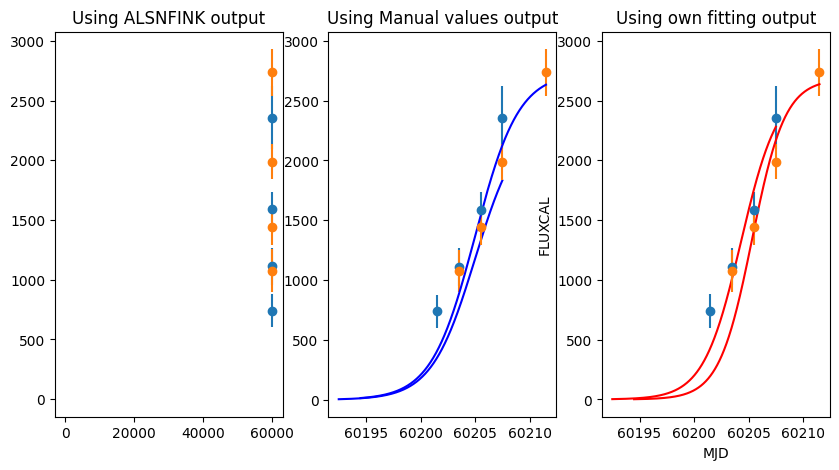

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

for filt in df["FLT"].unique():
    sel_flt = df[df["FLT"] == filt]
    jd = sel_flt.MJD.values - 2400000.5
    flux = sel_flt.FLUXCAL.values
    eflux = sel_flt.FLUXCALERR.values
    for i in range(3):
        axs[i].errorbar(
            jd,
            flux,
            eflux,
            ls="",
            marker="o",
            color=colordic[filt],
            label=filt,
        )
    # extenging x axis
    new_jd = [float(jd.min()) -i for i in range(1,10)] + list(jd)

    # using ALSNFINK output
    jd_fitted = np.linspace(min(new_jd), max(new_jd), 1000)
    jd_fitted2 = np.linspace(0, max(new_jd)-min(new_jd), 1000)
    flux_fitted = sigmoid(jd_fitted2, alerts_features[f"a_{filt}"].values[0], alerts_features[f"b_{filt}"].values[0], alerts_features[f"c_{filt}"].values[0])    
    axs[0].plot(jd_fitted2, flux_fitted,  color="orange")
    axs[0].set_title("Using ALSNFINK output")

    # Manual input
    flux_fitted = sigmoid(jd_fitted, flux.max(), 0.5, 60205) 
    axs[1].plot(jd_fitted, flux_fitted, color="blue")
    axs[1].set_title("Using Manual values output")

    # testing fitting myself
    initial_guess = [flux.max(), 0.5, 60205]
    bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
    new_flux = [0 for i in range(1,10)] + [float(k) for k in flux]
    popt, pcov = curve_fit(sigmoid, new_jd, new_flux, p0=initial_guess, bounds=bounds, maxfev=10000)
    c, a, b = popt
    flux_fitted = sigmoid(jd_fitted, c,a,b)    
    axs[2].plot(jd_fitted, flux_fitted,  color="red")
    axs[2].set_title("Using own fitting output")
    print('out')
    print(c, a, b)

    

plt.xlabel("MJD")
plt.ylabel("FLUXCAL")
